In [14]:
import os

data_dir = "cell_images"  
parasitized_dir = os.path.join(data_dir, "Parasitized")
uninfected_dir = os.path.join(data_dir, "Uninfected")

print("Parasitized tasvirlar soni:", len(os.listdir(parasitized_dir)))
print("Uninfected tasvirlar soni:", len(os.listdir(uninfected_dir)))

Parasitized tasvirlar soni: 13780
Uninfected tasvirlar soni: 13780


In [15]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
datagen = ImageDataGenerator(
    rescale=1.0/255,  
    validation_split=0.2  
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),  
    batch_size=32,  
    class_mode='binary',  
    subset='training',  
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation', 
    shuffle=False
)

print("Sinflar:", train_generator.class_indices)

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.
Sinflar: {'Parasitized': 0, 'Uninfected': 1}


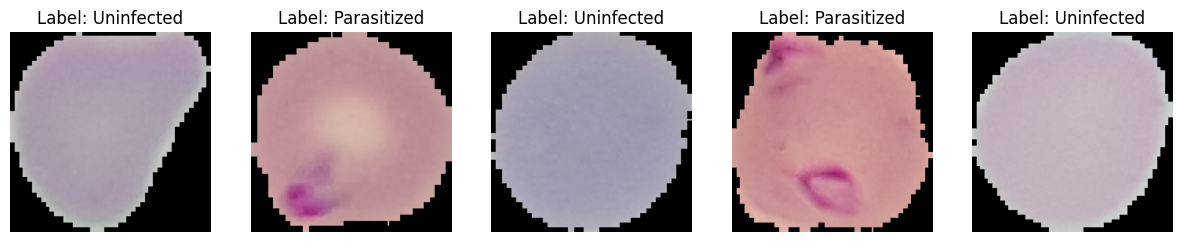

In [5]:
def show_sample_images(generator, num_samples=5):
    images, labels = next(generator)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        axes[i].imshow(images[i])
        axes[i].set_title(f"Label: {'Parasitized' if labels[i] == 0 else 'Uninfected'}")
        axes[i].axis('off')
    plt.show()

show_sample_images(train_generator)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [7]:
def create_cnn_model(input_shape=(128, 128, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        
        Dense(128, activation='relu'),
        Dropout(0.5),  
        Dense(1, activation='sigmoid') 
    ])
    return model

model = create_cnn_model()
model.summary() 

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    zoom_range=0.2,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=test_generator.samples // 32,
    callbacks=[early_stopping, lr_scheduler]
)

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 106s 151ms/step - accuracy: 0.5666 - loss: 0.6797 - val_accuracy: 0.9137 - val_loss: 0.3080 - learning_rate: 0.0010
Epoch 2/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 98s 142ms/step - accuracy: 0.9057 - loss: 0.2809 - val_accuracy: 0.9442 - val_loss: 0.1804 - learning_rate: 0.0010
Epoch 3/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 112s 163ms/step - accuracy: 0.9289 - loss: 0.2232 - val_accuracy: 0.9466 - val_loss: 0.1800 - learning_rate: 0.0010
Epoch 4/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 107s 156ms/step - accuracy: 0.9330 - loss: 0.2063 - val_accuracy: 0.9422 - val_loss: 0.1753 - learning_rate: 0.0010
Epoch 5/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 96s 139ms/step - accuracy: 0.9319 - loss: 0.2095 - val_accuracy: 0.9506 - val_loss: 0.1655 - learning_rate: 0.0010
Epoch 6/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 96s 139ms/step - accuracy: 0.9327 - loss: 0.2028 - val_accuracy: 0.9428 - val_loss: 0.1663 - learning_rate: 0.0010
Epoch 7/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 99s 143ms/step - accuracy: 

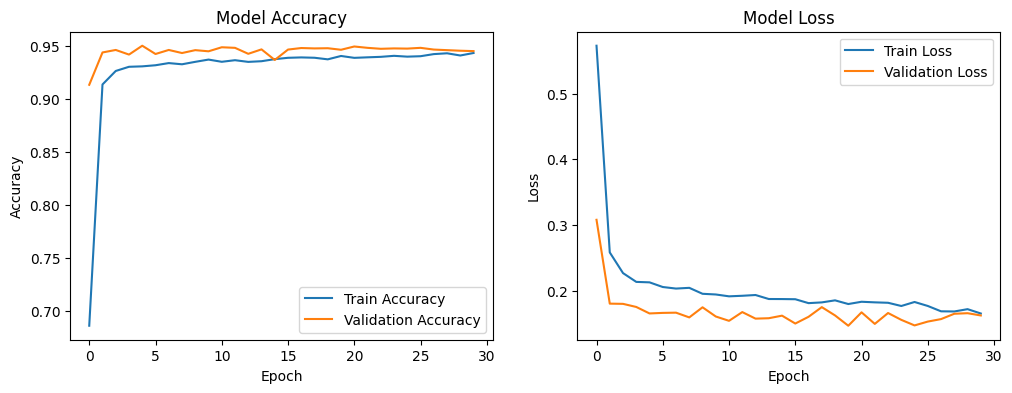

In [ ]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.show()

plot_training_history(history)

173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9339 - loss: 0.1870
Test to‘plamida aniqlik: 0.9468
Test to‘plamida yo‘qotish: 0.1467
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step


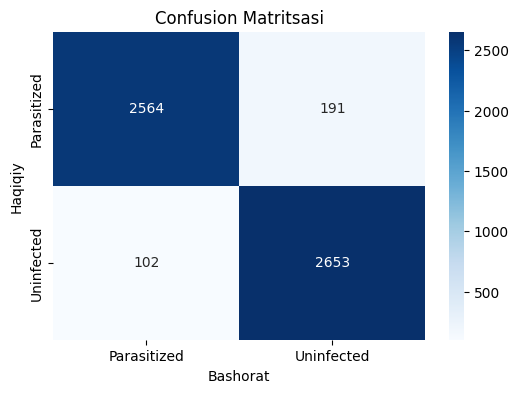

In [13]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test to‘plamida aniqlik: {test_accuracy:.4f}")
print(f"Test to‘plamida yo‘qotish: {test_loss:.4f}")

import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = (model.predict(test_generator) > 0.5).astype("int32")
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Parasitized', 'Uninfected'],
            yticklabels=['Parasitized', 'Uninfected'])
plt.title('Confusion Matritsasi')
plt.xlabel('Bashorat')
plt.ylabel('Haqiqiy')
plt.show()

In [12]:
model.save('malaria_cnn_model.h5')